In [60]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as pdr
import yfinance as yf
from helper_functions import *
import talib as ta
from talib import MA_Type
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
symbols = {"SoftBank": "9984.T", "Rakuten": "4755.T", "Ajinomoto": "2802.T", "TOYOTA": "7203.T"}
data_length = 30

sb = get_data(symbols["Rakuten"], data_length)

[*********************100%***********************]  1 of 1 completed


In [56]:
sb.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-04-19,398.0,644.0,360.0,600.0,571.375549,4000000
2000-04-20,610.0,808.0,606.0,800.0,761.834045,3000000
2000-04-21,792.0,980.0,790.0,860.0,818.971497,2000000
2000-04-24,870.0,910.0,790.0,790.0,752.311157,1000000
2000-04-25,790.0,866.0,700.0,850.0,809.448669,1000000


In [58]:
transformed = np.log(sb["Low"]).diff()
transformed.head()

Date
2000-04-19         NaN
2000-04-20    0.520776
2000-04-21    0.265153
2000-04-24    0.000000
2000-04-25   -0.120953
Name: Low, dtype: float64

In [14]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(transformed)
result

(-16.376083161755908,
 2.780317904271207e-29,
 17,
 5415,
 {'1%': -3.4315581999292024,
  '5%': -2.862073902727173,
  '10%': -2.567054195520633},
 -21836.970807139878)

## Add Indicator

In [67]:
def preprocess_data(df, SMA=True, sma5=5, sma10=10, sma20=20,
              MACD=True, short_span=8, long_span=17, macd_span=9, 
              RSI=True, timeperiod=14, SOI=True, slowk_period=3, fastk_period=14, 
              Bband=True):
    # Fill the zero value on open price to previous closing price
    for i, open_price in enumerate(df["Open"]):
        if open_price == 0.0:
            df["Open"][i] = df["Adj Close"].iloc[i-1]
            
    df = df.iloc[1: , :]
            
    df["Closep"] = np.log(df["Adj Close"]).diff()
    df["Openp"] = (df["Adj Close"] - df["Open"]) / df["Open"]
    df["Highp"] = (df["High"] - df["Open"]) / df["Open"]
    df["Lowp"] = (df["Low"] - df["Open"]) / df["Open"]
    scaler = MinMaxScaler()
    df["Vol_scaled"] = scaler.fit_transform(df["Volume"].to_numpy().reshape(-1, 1))
    
    # SMA
    if SMA:
        df["SMA5"] = df["Adj Close"].rolling(sma5).mean()
        df["SMA10"] = df["Adj Close"].rolling(sma10).mean()
        df["SMA20"] = df["Adj Close"].rolling(sma20).mean()
        
        df["smap5"] = df["Closep"].rolling(sma5).mean()
        df["smap10"] = df["Closep"].rolling(sma10).mean()
        df["smap20"] = df["Closep"].rolling(sma20).mean()
        
        
    # MACD
    if MACD:
        # Calculate the short term exponential moving average
        shortEMA = df["Adj Close"].ewm(span=short_span, adjust=False).mean()
        # Calculate the long term exponential moving average
        longEMA = df["Adj Close"].ewm(span=long_span, adjust=False).mean()
        # Calculate MACD line
        MACD = shortEMA - longEMA
        # calculate the signal line
        signal = MACD.ewm(span=macd_span, adjust=False).mean()
        # Add to the DataFrame
        df["MACD"] = MACD
        df["Signal Line"] = signal
        
        # Calculate the short term exponential moving average with stationary data
        shortEMA = df["Closep"].ewm(span=short_span, adjust=False).mean()
        # Calculate the long term exponential moving average
        longEMA = df["Closep"].ewm(span=long_span, adjust=False).mean()
        # Calculate MACD line
        MACD = shortEMA - longEMA
        # calculate the signal line
        signal = MACD.ewm(span=macd_span, adjust=False).mean()
        # Add to the DataFrame
        df["macdp"] = MACD
        df["signal_linep"] = signal
        
    # RSI
    if RSI:
        df["RSI"] = ta.RSI(df["Adj Close"], timeperiod=timeperiod)
        
        df["rsip"] = ta.RSI(df["Closep"], timeperiod=timeperiod)
        
    # Stochastic
    if SOI:
        df["SlowK"], df["SlowD"] = ta.STOCH(high=df["High"],
                                   low=df["Low"],
                                   close=df["Adj Close"], 
                                   slowk_period=slowk_period,
                                   fastk_period=fastk_period)
        
        df["slowKp"], df["slowDp"] = ta.STOCH(high=df["Highp"],
                                   low=df["Lowp"],
                                   close=df["Closep"], 
                                   slowk_period=slowk_period,
                                   fastk_period=fastk_period)
        
    # Bollinger Band
    if Bband:
        df["Bband_upper"], df["Bband_mid"], df["Bband_lower"] = ta.BBANDS(df["Adj Close"], matype=MA_Type.T3)
        
        df["BBuperp"], df["BBmidp"], df["BBlowp"] = ta.BBANDS(df["Closep"], matype=MA_Type.T3)
        
    df.dropna(inplace=True)
        
    return df

In [68]:
symbol = "AMD"
amd = get_data(symbol, 50) 
amd = preprocess_data(amd)
amd.head()

[*********************100%***********************]  1 of 1 completed


<ipython-input-67-b1bf7de204ca>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Open"][i] = df["Adj Close"].iloc[i-1]
<ipython-input-67-b1bf7de204ca>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Closep"] = np.log(df["Adj Close"]).diff()
<ipython-input-67-b1bf7de204ca>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

,Open,High,Low,Close,Adj Close,Volume,Closep,Openp,Highp,Lowp,...,SlowK,SlowD,slowKp,slowDp,Bband_upper,Bband_mid,Bband_lower,BBuperp,BBmidp,BBlowp
Date,,,,,,,,,,,,,,,,,,,,,
1980-04-23,2.561793,2.729167,2.593750,2.614583,2.613862,588000,0.020121,0.020325,0.065335,0.012474,...,43.612719,27.644920,58.983358,51.116436,2.669931,2.414982,2.160034,0.111879,0.007116,-0.097648
1980-04-24,2.613862,2.812500,2.614583,2.781250,2.780483,733200,0.061796,0.063745,0.075994,0.000276,...,73.628967,47.138453,67.475260,59.152249,2.842588,2.474087,2.105587,0.132964,0.023061,-0.086842
1980-04-25,2.780483,2.760417,2.687500,2.708333,2.707586,343200,-0.026567,-0.026217,-0.007217,-0.033441,...,81.108708,66.116798,46.694251,57.717623,2.879497,2.543818,2.208139,0.128776,0.027277,-0.074222
1980-04-28,2.707586,2.791667,2.718750,2.729167,2.728414,372000,0.007663,0.007693,0.031054,0.004123,...,86.398940,80.378872,44.821886,52.997132,2.768338,2.609501,2.450664,0.121034,0.025700,-0.069634
1980-04-29,2.728414,2.729167,2.635417,2.666667,2.665931,270000,-0.023167,-0.022901,0.000276,-0.034085,...,79.349633,82.285760,32.052660,41.189599,2.768735,2.655881,2.543027,0.082834,0.018291,-0.046252


In [18]:
amd.all()

Open             True
High             True
Low              True
Close            True
Adj Close        True
Volume          False
Closep          False
Openp           False
Highp           False
Lowp            False
Volumep         False
SMA5             True
SMA10            True
SMA20            True
smap5           False
smap10          False
smap20          False
MACD             True
Signal Line      True
macdp            True
signal_linep     True
RSI              True
rsip             True
SlowK            True
SlowD            True
slowKp           True
slowDp           True
Bband_upper      True
Bband_mid        True
Bband_lower      True
BBuperp          True
BBmidp           True
BBlowp           True
dtype: bool

In [69]:
amd["Vol_scaled"].head(10)

Date
1980-04-23    0.001809
1980-04-24    0.002256
1980-04-25    0.001056
1980-04-28    0.001144
1980-04-29    0.000831
1980-04-30    0.000842
1980-05-01    0.001554
1980-05-02    0.000868
1980-05-05    0.000930
1980-05-06    0.001189
Name: Vol_scaled, dtype: float64

In [70]:
amd.shape

(10581, 33)

In [71]:
amd[amd["smap5"] == 0]

,Open,High,Low,Close,Adj Close,Volume,Closep,Openp,Highp,Lowp,...,SlowK,SlowD,slowKp,slowDp,Bband_upper,Bband_mid,Bband_lower,BBuperp,BBmidp,BBlowp
Date,,,,,,,,,,,,,,,,,,,,,
1980-05-13,2.613862,2.708333,2.656250,2.687500,2.686759,213600,0.027507,0.027889,0.036142,0.016217,...,51.995494,53.255956,44.572317,29.024070,2.726914,2.616390,2.505867,0.053093,0.002982,-0.047130
1980-07-18,3.644827,3.729167,3.614583,3.614583,3.613586,422400,-0.008608,-0.008571,0.023140,-0.008298,...,75.517879,80.193846,28.725840,32.065674,3.783193,3.687658,3.592123,0.040422,0.002378,-0.035666
1980-09-04,4.436276,4.541667,4.447917,4.479167,4.477931,435600,0.009346,0.009390,0.023757,0.002624,...,56.646747,50.338450,58.748067,45.998605,4.582509,4.397342,4.212175,0.050670,-0.001156,-0.052982
1980-10-13,5.165242,5.395833,5.229167,5.375000,5.373518,213600,0.039531,0.040323,0.044643,0.012376,...,57.727783,61.746287,51.475621,48.801809,5.619565,5.375393,5.131222,0.075144,0.002272,-0.070599
1981-05-27,4.582069,4.666667,4.500000,4.562500,4.561242,444600,-0.004556,-0.004545,0.018463,-0.017911,...,54.108021,55.821972,46.386231,44.532611,4.624974,4.539200,4.453427,0.031523,0.000107,-0.031308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-17,1.850000,1.940000,1.850000,1.900000,1.900000,13770200,0.037538,0.027027,0.048649,0.000000,...,11.111128,8.562425,57.057460,49.686545,1.896300,1.843536,1.790772,0.040676,-0.006822,-0.054319
2016-04-13,2.780000,2.820000,2.730000,2.800000,2.800000,8048000,-0.003565,0.007194,0.014388,-0.017986,...,48.648650,39.939953,58.390292,58.884908,2.878998,2.757672,2.636346,0.066814,0.002115,-0.062584
2016-04-18,2.670000,2.800000,2.650000,2.760000,2.760000,8938800,0.021979,0.033708,0.048689,-0.007491,...,31.531555,37.237254,47.557237,44.467794,2.830782,2.744619,2.658457,0.035037,-0.001980,-0.038998


In [72]:
amd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10581 entries, 1980-04-23 to 2022-04-07
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          10581 non-null  float64
 1   High          10581 non-null  float64
 2   Low           10581 non-null  float64
 3   Close         10581 non-null  float64
 4   Adj Close     10581 non-null  float64
 5   Volume        10581 non-null  int64  
 6   Closep        10581 non-null  float64
 7   Openp         10581 non-null  float64
 8   Highp         10581 non-null  float64
 9   Lowp          10581 non-null  float64
 10  Vol_scaled    10581 non-null  float64
 11  SMA5          10581 non-null  float64
 12  SMA10         10581 non-null  float64
 13  SMA20         10581 non-null  float64
 14  smap5         10581 non-null  float64
 15  smap10        10581 non-null  float64
 16  smap20        10581 non-null  float64
 17  MACD          10581 non-null  float64
 18  Signal Li

In [73]:
amd.describe()

,Open,High,Low,Close,Adj Close,Volume,Closep,Openp,Highp,Lowp,...,SlowK,SlowD,slowKp,slowDp,Bband_upper,Bband_mid,Bband_lower,BBuperp,BBmidp,BBlowp
count,10581.000000,10581.000000,10581.000000,10581.000000,10581.000000,1.058100e+04,10581.000000,10581.000000,10581.000000,10581.000000,...,10581.000000,10581.000000,10581.000000,10581.000000,10581.000000,10581.000000,10581.000000,10581.000000,10581.000000,10581.000000
mean,15.144878,15.463027,14.801769,15.133994,15.133134,1.675066e+07,0.000350,-0.000304,0.021951,-0.022697,...,50.628341,50.629484,48.698303,48.699163,15.927409,15.116383,14.305357,0.057203,0.000360,-0.056483
std,19.982149,20.387161,19.532923,19.966142,19.966314,2.621596e+07,0.037585,0.032167,0.023955,0.022251,...,28.650197,27.850047,17.521283,15.236506,20.962688,19.931323,18.928386,0.038264,0.015886,0.040103
min,1.620000,1.690000,1.610000,1.620000,1.620000,0.000000e+00,-0.476924,-0.281448,-0.039339,-0.400000,...,-0.206900,1.639748,-108.541655,-89.140912,1.736993,1.684728,1.455815,-0.019630,-0.112321,-0.491317
25%,5.186069,5.312500,5.062500,5.187500,5.186069,1.194000e+06,-0.018576,-0.018182,0.006579,-0.031915,...,23.510043,24.498740,36.831819,38.213826,5.533705,5.172610,4.846782,0.031863,-0.008507,-0.070410
50%,9.531250,9.750000,9.312500,9.500000,9.500000,6.332400e+06,0.000000,-0.000276,0.015075,-0.017070,...,51.676870,51.971326,48.438675,48.519145,10.028650,9.522511,8.989766,0.048777,0.000159,-0.048233
75%,15.540000,15.830000,15.250000,15.500000,15.500000,2.068620e+07,0.019418,0.016206,0.030075,-0.007491,...,77.142728,76.402918,60.439960,59.004105,16.233298,15.471574,14.725884,0.072669,0.009444,-0.031572
max,163.279999,164.460007,156.100006,161.910004,161.910004,3.250584e+08,0.420617,0.273885,0.273885,0.112376,...,99.858229,98.120092,127.238535,121.218927,166.856348,157.338668,150.855171,0.450756,0.080501,0.034416


Biggest increase from previous day: 2016-04-22 00:00:00
Change in %: 42.06
Biggest decrease from prvious day: 1992-06-18 00:00:00
Change in %: -47.69


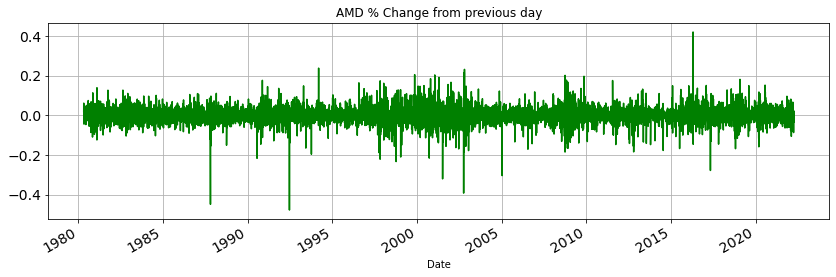

In [26]:
amd["Closep"].plot(color="g", title=symbol + " " + "% Change from previous day", fontsize=14, figsize=(14, 4)).grid()
print("Biggest increase from previous day: " + str(amd["Closep"].idxmax()))
print("Change in %: " + str(np.round(amd["Closep"].max() * 100, 2)))
print("Biggest decrease from prvious day: " + str(amd["Closep"].idxmin()))
print("Change in %: " + str(np.round(amd["Closep"].min() * 100, 2)))

In [54]:
amd.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Closep',
       'Openp', 'Highp', 'Lowp', 'Volumep', 'SMA5', 'SMA10', 'SMA20', 'smap5',
       'smap10', 'smap20', 'MACD', 'Signal Line', 'macdp', 'signal_linep',
       'RSI', 'rsip', 'SlowK', 'SlowD', 'slowKp', 'slowDp', 'Bband_upper',
       'Bband_mid', 'Bband_lower', 'BBuperp', 'BBmidp', 'BBlowp'],
      dtype='object')

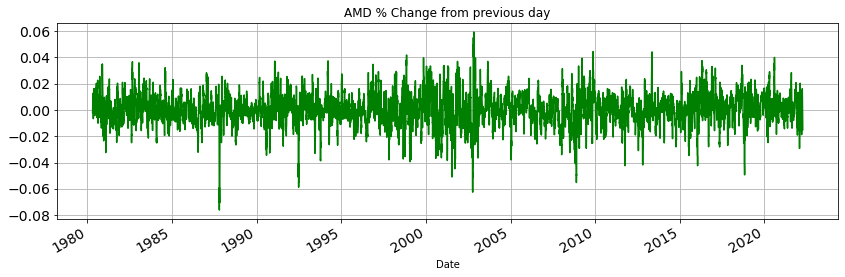

In [30]:
amd["smap10"].plot(color="g", title=symbol + " " + "% Change from previous day", fontsize=14, figsize=(14, 4)).grid()

In [74]:
# Find out the which column is the non-stationary data
cols = list(amd.columns)
for col in cols:
    try:
        print(col, ":", adfuller(amd[col])[1])
    except:
        print(col)

Open : 0.9161930162454157
High : 0.8603438231639892
Low : 0.939423783402104
Close : 0.9137679326918879
Adj Close : 0.913779932832536
Volume : 0.037140920629962874
Closep : 0.0
Openp : 0.0
Highp : 2.4689559220697694e-17
Lowp : 5.986395699827035e-17
Vol_scaled : 0.037140920629946804
SMA5 : 0.9930440784881039
SMA10 : 0.9947910773058958
SMA20 : 0.9985409550337055
smap5 : 2.350501987926393e-28
smap10 : 9.425842620704146e-29
smap20 : 3.8525851010279867e-28
MACD : 2.3910825657684105e-24
Signal Line : 1.7401047070172745e-19
macdp : 0.0
signal_linep : 0.0
RSI : 4.615432910452579e-29
rsip : 0.0
SlowK : 1.680490218983679e-24
SlowD : 1.1238469141705907e-24
slowKp : 1.5691995132431057e-28
slowDp : 1.9661903704023542e-27
Bband_upper : 0.9792408457316959
Bband_mid : 0.9937559298689826
Bband_lower : 0.9883179677501125
BBuperp : 2.0709223929229686e-20
BBmidp : 0.0
BBlowp : 9.927456350043754e-20


In [75]:
# Correlation coefficient matrix
corr = amd.corr()
close_corr = corr[["Closep", "Adj Close"]].sort_values("Adj Close", ascending=False)
close_corr

,Closep,Adj Close
Adj Close,0.018855,1.000000
Close,0.018856,1.000000
High,0.009129,0.999704
Low,0.009352,0.999684
Open,-0.000403,0.999287
SMA5,-0.001990,0.998958
Bband_mid,-0.004171,0.998584
Bband_upper,-0.004187,0.998002
Bband_lower,-0.004148,0.997728
SMA10,-0.004506,0.997560


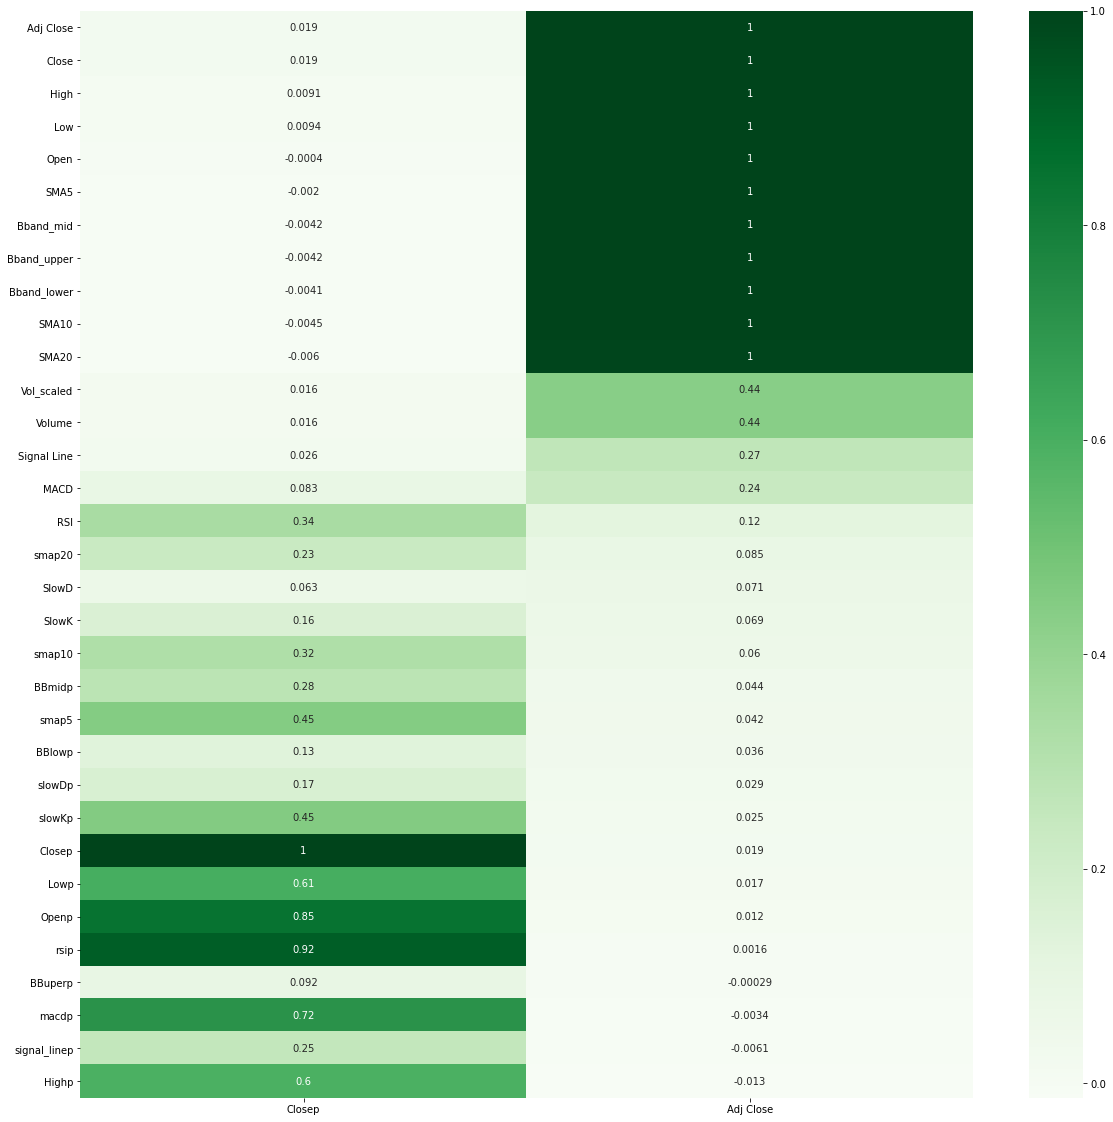

In [76]:
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(close_corr, annot=True, cmap="Greens")

In [77]:
amd.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Closep',
       'Openp', 'Highp', 'Lowp', 'Vol_scaled', 'SMA5', 'SMA10', 'SMA20',
       'smap5', 'smap10', 'smap20', 'MACD', 'Signal Line', 'macdp',
       'signal_linep', 'RSI', 'rsip', 'SlowK', 'SlowD', 'slowKp', 'slowDp',
       'Bband_upper', 'Bband_mid', 'Bband_lower', 'BBuperp', 'BBmidp',
       'BBlowp'],
      dtype='object')

In [78]:
def split_stationary_nonstationary(df):
    stationary_df = df[["Closep", "Openp", "Highp", "Lowp", "Vol_scaled", "smap5", "smap10", "smap20", "macdp",
                        "signal_linep", "rsip", "slowKp", "slowDp", "BBuperp", "BBmidp", "BBlowp"]]

    non_stationary_df = df[["Open", "High", "Low", "Adj Close", "Volume", "SMA5", "SMA10", "SMA20", "MACD",
                            "Signal Line", "RSI", "SlowK", "SlowD", 'Bband_upper', 'Bband_mid', 'Bband_lower']]
    
    return stationary_df, non_stationary_df

In [79]:
st_df, non_st_df = split_stationary_nonstationary(amd)

In [80]:
st_corr = st_df.corr()
st_corr["Closep"].sort_values(ascending=False)

Closep          1.000000
rsip            0.919034
Openp           0.846108
macdp           0.718450
Lowp            0.607101
Highp           0.595652
slowKp          0.451309
smap5           0.448889
smap10          0.319555
BBmidp          0.279582
signal_linep    0.253012
smap20          0.233816
slowDp          0.169256
BBlowp          0.133854
BBuperp         0.091857
Vol_scaled      0.015674
Name: Closep, dtype: float64

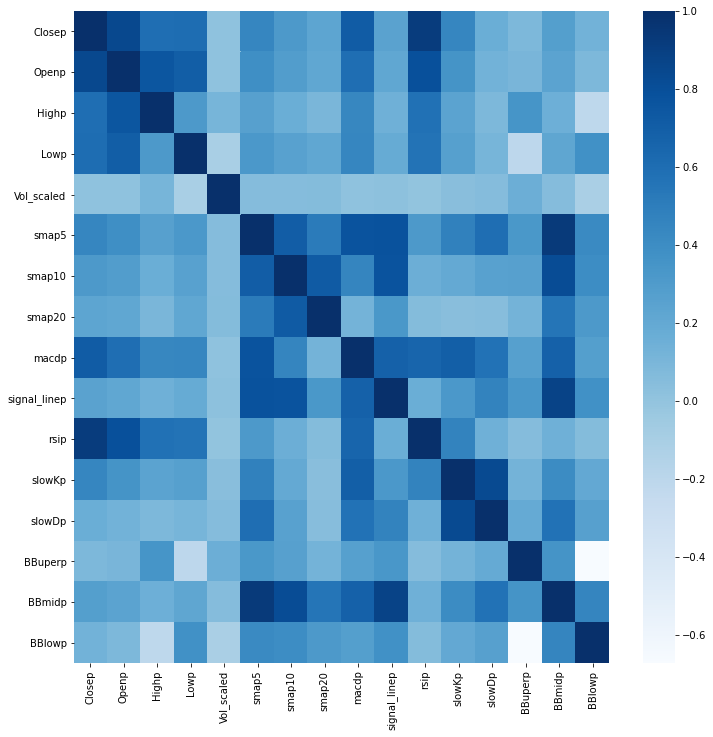

In [87]:
plt.figure(figsize=(12, 12))
st_df_heatmap = sns.heatmap(st_corr, cmap="Blues");

## Evaluation metrics

* MAE
* RMSE
* MAPE
* sMAPE

In [88]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

## Baseline:

#### ARIMA model for baseline: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

#### sktime: https://www.tensorflow.org/decision_forests

#### Facebook Kats: https://github.com/facebookresearch/Kats

## Create sequential Data

Split the data 

Windowing

In [90]:
feature = st_df.drop("Closep", axis=1)
target = st_df["Closep"]

,Openp,Highp,Lowp,Vol_scaled,smap5,smap10,smap20,macdp,signal_linep,rsip,slowKp,slowDp,BBuperp,BBmidp,BBlowp
Date,,,,,,,,,,,,,,,
1980-04-23,0.020325,0.065335,0.012474,0.001809,0.020984,-0.001972,0.000200,0.009885,0.001660,51.041341,58.983358,51.116436,0.111879,0.007116,-0.097648
1980-04-24,0.063745,0.075994,0.000276,0.002256,0.027242,0.001509,0.006383,0.014179,0.004164,53.494788,67.475260,59.152249,0.132964,0.023061,-0.086842
1980-04-25,-0.026217,-0.007217,-0.033441,0.001056,0.030702,0.002729,0.006567,0.006979,0.004727,48.002020,46.694251,57.717623,0.128776,0.027277,-0.074222
1980-04-28,0.007693,0.031054,0.004123,0.001144,0.034943,0.006301,0.003559,0.005632,0.004908,50.137893,44.821886,52.997132,0.121034,0.025700,-0.069634
1980-04-29,-0.022901,0.000276,-0.034085,0.000831,0.007969,0.003985,0.002400,0.001137,0.004154,48.216851,32.052660,41.189599,0.082834,0.018291,-0.046252


In [92]:
target.head()

Date
1980-04-23    0.020121
1980-04-24    0.061796
1980-04-25   -0.026567
1980-04-28    0.007663
1980-04-29   -0.023167
Name: Closep, dtype: float64

In [97]:
def split_data(df, split_size):
    split_size = int(split_size * len(df))
    X_train, y_train = df[:split_size], df[:split_size]
    X_test, y_test = df[split_size:], df[split_size:]
    
    return X_train, y_train, X_test, y_test

In [98]:
X_train, y_train, X_test, y_test = split_data(st_df, 0.8)

In [100]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8464, 16), (8464, 16), (2117, 16), (2117, 16))

In [104]:
test_window, test_label = get_labelled_windows(x=tf.expand_dims(st_df, axis=0), horizon=1)
test_window, test_label

(<tf.Tensor: shape=(1, 10580, 16), dtype=float64, numpy=
 array([[[ 0.02012131,  0.0203251 ,  0.06533467, ...,  0.11187913,
           0.00711572, -0.09764769],
         [ 0.06179583,  0.06374513,  0.07599415, ...,  0.13296448,
           0.0230613 , -0.08684189],
         [-0.02656718, -0.02621737, -0.00721665, ...,  0.12877579,
           0.02727684, -0.07422211],
         ...,
         [ 0.021398  ,  0.00509228,  0.0088206 , ...,  0.06163971,
          -0.02000872, -0.10165715],
         [-0.03414179, -0.02616467,  0.00720212, ...,  0.04927159,
          -0.02131979, -0.09191117],
         [-0.02993241, -0.00746768,  0.01235042, ...,  0.04719451,
          -0.0232811 , -0.09375671]]])>,
 <tf.Tensor: shape=(1, 1, 16), dtype=float64, numpy=
 array([[[ 4.82212767e-04, -1.92452802e-03,  1.27020758e-02,
          -2.89645358e-02,  2.82441247e-01, -1.05534575e-02,
          -1.50203702e-02, -1.30371734e-03, -4.68185462e-03,
          -4.08330033e-03,  5.06013906e+01,  3.72676504e+01,
    

In [106]:
st_df[-1:]

,Closep,Openp,Highp,Lowp,Vol_scaled,smap5,smap10,smap20,macdp,signal_linep,rsip,slowKp,slowDp,BBuperp,BBmidp,BBlowp
Date,,,,,,,,,,,,,,,,
2022-04-07,0.000482,-0.001925,0.012702,-0.028965,0.282441,-0.010553,-0.01502,-0.001304,-0.004682,-0.004083,50.601391,37.26765,42.588842,0.018681,-0.022059,-0.062798


### Forcasting at Uber: https://eng.uber.com/forecasting-introduction/